# Initial Block

In [1]:
import os
import glob
import time
import joblib


import tensorflow as tf
import pandas as pd
import numpy as np
import json
from datetime import datetime


import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from glob import glob
from datetime import datetime
import subprocess
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

print("Tensorflow version ",tf.__version__)



from utils.utilities import devtools
from nntool import unet


dtools = devtools()

Tensorflow version  2.0.0


In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6727869750724173141
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18135645683947518029
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16256124514644094541
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1555496960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7443517761592873564
physical_device_desc: "device: 0, name: GeForce 920M, pci bus id: 0000:08:00.0, compute capability: 3.5"
]


# Directory Structure

In [3]:
! tree  -L 3 ../data/coco-person/ --filelimit 5

../data/coco-person/
├── train
│   ├── person_images
│   │   └── images
│   └── person_masks
│       └── masks
└── val
    ├── person_images
    │   └── images
    └── person_masks
        └── masks

10 directories, 0 files


# Get Data ids

In [4]:
def get_data_ids():
    train_imgs = []
    train_masks = []
    
    val_imgs = []
    val_masks = []
    
    common_path = "../data/coco-person/"
    paths = [
        "train/person_images/images/*", "train/person_masks/masks/*", 
        "val/person_images/images/*", "val/person_masks/masks/*" ]
    # final list var will have => [train_imgs, train_masks, val_imgs, val_masks]
    
    var = []
    
    for i in paths:
        # print(os.path.join(common_path,i))
        var.append(glob(os.path.join(common_path,i)))
        
    return var


train_imgs_dir = "../data/coco-person/train/person_images/"
train_masks_dir = "../data/coco-person/train/person_masks/"

val_imgs_dir = "../data/coco-person/val/person_images/"
val_masks_dir = "../data/coco-person/val/person_masks/"


X_train, y_train, X_test, y_test = get_data_ids()

In [5]:
print("total training person images {" ":>10}".format(len(X_train)))
print("total training person masks {" ":>11}".format(len(y_train)))

print("total validation person images {" ":>8}".format(len(X_test)))
print("total validation person masks {" ":>9}".format(len(y_test)))

total training person images      64115
total training person masks       64115
total validation person images     2693
total validation person masks      2693


# Parameters

In [6]:
batch_size = 8
epochs = 15


SEED = 3017 
IMG_HEIGHT = 256
IMG_WIDTH = 256
input_image_channels = 1

if input_image_channels == 3:
    color_mode='rgb'
if input_image_channels == 1:
    color_mode='grayscale'
    
    
steps_per_epoch= (len(X_train) // batch_size)
validation_steps = (len(X_test) // batch_size)


# Image Data Generator

In [7]:

image_datagen = ImageDataGenerator(
    rotation_range=45,
    horizontal_flip = True,
    # vertical_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True,
)


mask_datagen = ImageDataGenerator(
    rotation_range=45,
    horizontal_flip = True,
    # vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    
)



# Flow from directory

## train generators

In [8]:

train_img_generator = image_datagen.flow_from_directory(batch_size=batch_size,
                                                       directory=train_imgs_dir,
                                                       shuffle=True,
                                                       target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                       class_mode=None,
                                                       color_mode=color_mode,
                                                       seed=SEED)


train_mask_generator = image_datagen.flow_from_directory(batch_size=batch_size,
                                                       directory=train_masks_dir,
                                                       shuffle=True,
                                                       target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                       class_mode=None,
                                                       color_mode='grayscale',
                                                       seed = SEED)

Found 64115 images belonging to 1 classes.
Found 64115 images belonging to 1 classes.


## validation generators

In [9]:
val_img_generator = image_datagen.flow_from_directory(batch_size=batch_size,
                                                       directory=val_imgs_dir,
                                                       shuffle=True,
                                                       target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                       class_mode=None,
                                                       color_mode=color_mode,
                                                      
                                                       seed=SEED)


val_mask_generator = image_datagen.flow_from_directory(batch_size=batch_size,
                                                       directory=val_masks_dir,
                                                       shuffle=True,
                                                       target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                       class_mode=None,
                                                       color_mode='grayscale',
                                                       seed = SEED)

val_generator = zip(val_img_generator, val_mask_generator)

Found 2693 images belonging to 1 classes.
Found 2693 images belonging to 1 classes.


In [10]:
def image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [11]:
for i in range(validation_steps+2):
    t = train_img_generator.filenames
    next(val_mask_generator)
    break

In [12]:
pd.Series(t).unique().shape

(64115,)

# Visualise generator images

In [13]:
sample_images = next(train_img_generator)
sample_masks = next(train_mask_generator)

In [14]:
def plot_sample_batch_images(images_arr):
    fig, axes = plt.subplots(1,5, figsize=(20,20))
    axes = axes.flatten()
    
    for img,ax in zip(images_arr, axes):
        ax.imshow(array_to_img(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    

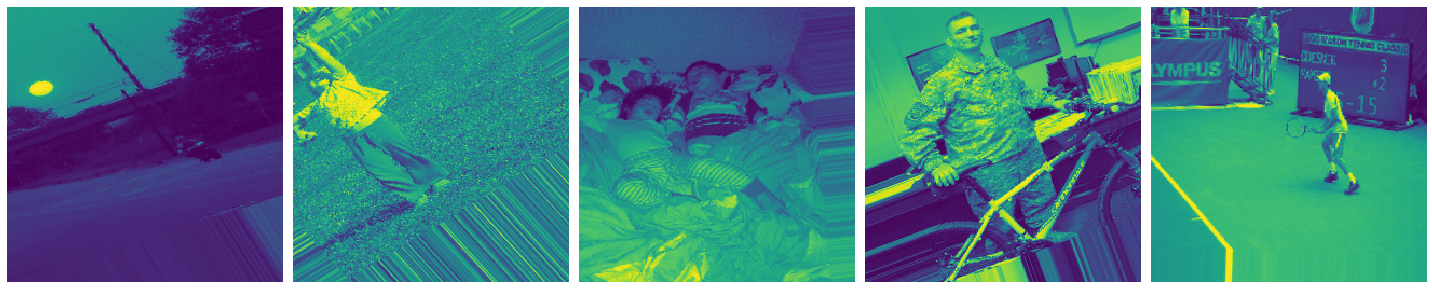

In [15]:
plot_sample_batch_images(sample_images[:5])

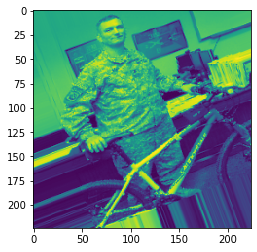

In [18]:
plt.imshow(np.squeeze((resize(sample_images[3],(224,224)))))

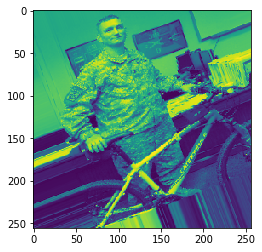

In [25]:
X = sample_images[3]
mu = sample_images[3].mean()
std = sample_images[3].std()

plt.imshow(np.squeeze((X-mu)/std))

In [ ]:
_ = X

f=(_).flatten()

t = plt.hist(f,bins=200)

In [21]:
# plot_sample_batch_images(sample_masks[:5])

# Create Model

In [22]:
IMG_HEIGHT, IMG_WIDTH = (224,224)

In [ ]:
model = unet.custom_unet(depth=4,input_shape=(IMG_HEIGHT, IMG_WIDTH, input_image_channels), verbose=True)
model.compile(optimizer=Adam(lr=1e-4), loss=unet.dice_coef_loss, metrics=[unet.dice, unet.iou])